## Boostrap

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/FOMCDrift/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FOMCDrift\root\src")
from Regression import Regression

In [6]:
df_tmp = Regression().prep_regression()

In [96]:
def _ols(df: pd.DataFrame, in_sample_ratio: float) -> pd.DataFrame: 
    
    df_tmp = (df.sample(
        frac = in_sample_ratio))
    
    model = (sm.OLS(
        endog = df_tmp.PX_bps,
        exog  = sm.add_constant(df_tmp.drop(columns = ["PX_bps"]))).
        fit())
    
    params = model.params
    alpha  = params["const"]
    
    df_param = (params.to_frame(
        name = "beta").
        reset_index().
        rename(columns = {"index": "variable"}))
    
    df_out = (df.reset_index().melt(
        id_vars = ["event", "PX_bps"]).
        merge(right = df_param, how = "inner", on = ["variable"]).
        assign(beta_val = lambda x: x.beta * x.value).
        pivot(index = ["event", "PX_bps"], columns = "variable", values = "beta_val").
        sum(axis = 1).
        to_frame(name = "predict").
        reset_index().
        assign(signal_rtn = lambda x: np.sign(x.predict) * x.PX_bps))
    
    return df_out

def _bootstrap_ols(df: pd.DataFrame, sims: int, in_sample_ratio: float) -> pd.DataFrame: 
    
    df_tmp = df.drop(columns = [
        "variable"])

    df_exog = (df_tmp.query(
        "day == -4").
        drop(columns = ["date", "day", "PX_bps"]).
        fillna(0))

    df_endog = (df_tmp.query(
        "-3 <= day <= -1")
        [["event", "PX_bps"]].
        groupby("event").
        agg("mean"))

    df_combined = (df_endog.merge(
        right = df_exog, how = "inner", on = ["event"]).
        set_index("event"))
    
    df_date = (df_tmp.query(
        "day == -1")
        [["date", "event"]])
    
    df_out = (pd.concat([
        _ols(df_combined, in_sample_ratio).assign(sim = i + 1) 
        for i in range(sims)]).
        merge(right = df_date, how = "inner", on = ["event"]))
    
    return df_out


sims: int = 100
in_sample_ratio: float = 0.15

df_out = (df_tmp.query(
    "day != [0,1]").
    groupby("variable").
    apply(_bootstrap_ols, sims, in_sample_ratio).
    reset_index().
    drop(columns = ["level_1"]))

<AxesSubplot:xlabel='date'>

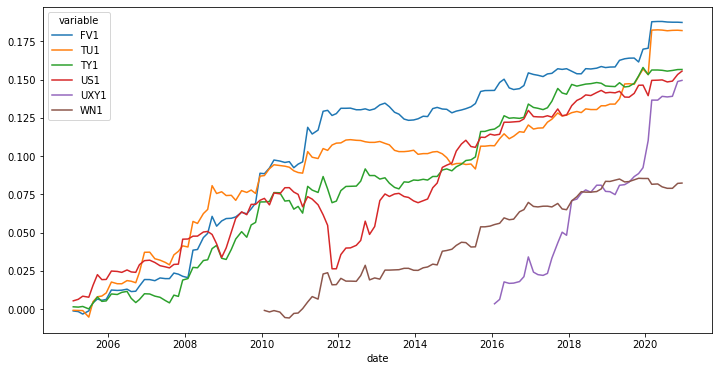

In [102]:
(df_out[
    ["variable", "signal_rtn", "date"]].
    groupby(["date", "variable"]).
    agg("mean").
    reset_index().
    pivot(index = "date", columns = "variable", values = "signal_rtn").
    cumsum().
    plot(
        figsize = (12,6)))